# TP cours - Comparez le comportement du lasso et de la régression ridge

  
expression gène du cancer = f(état du patient) 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## sklearn module : 
from sklearn import model_selection 
from sklearn import preprocessing


In [2]:
df = pd.read_csv(data_path+"TP_1_prostate_dataset.txt", delimiter = "\t")
df.head()

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
## DESIGN MATRICES : 
X = df.drop(["col", "lpsa","train"], axis = 1)
y = df.lpsa

## SPLIT DATA 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8)

## STANDARDIZE : 
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = my_std.transform(X_train)
X_test_std = my_std.transform(X_test)

# 1. Linear Regression : 

##### Model  : $\varepsilon \sim \mathcal{N}(0,\sigma^2)$
$$ y = X\beta + \varepsilon$$


##### Likelihood : 
$$ L = \prod_{i=1}^n \mathbb{P}[x^{(i)}, y^{(i)} | \beta ] $$
Max of log likelihood 
    $\Longleftrightarrow \underset{\beta \in  R^{p+1}}{\max} \left[  n \log(\frac{1}{\sigma \sqrt{2\pi}}) - \frac{1}{2\sigma^2} \sum_{i=1}^n  (f_{\beta}(x_i) - y_i )^2  \right]$
    $\Longleftrightarrow \underset{\beta \in  R^{p+1}}{\min} \left[ \sum_{i=1}^n  (f_{\beta}(x_i) - y_i )^2  \right]$


##### Least squares : 
Min of least squares : $ \underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta)$ 

In [4]:
from sklearn import linear_model

lm_lr = linear_model.LinearRegression(copy_X=True, fit_intercept=True, 
                                   n_jobs=1, normalize=False)
lm_lr.fit(X_train_std,y_train)
y_pred = lm_lr.predict(X_test_std)
R2_lr = lm_lr.score(X_test_std, y_test)
R2_lr

0.69138225781245

Mean Square Error : ("erreur quadratique moyenne")
$$ MSE = \frac{1}{n} \sum^n_{i=1} (f(x_i) - y_i)^2 $$

In [5]:
MSE_lr = ((y_pred-y_test)**2).mean()
MSE_lr

0.6257550816227854

We will need to define the score given by the MSE :
##TODO : TO BE REMOVED - It is possible to di without that :) 

In [6]:
## DEFINE MSE SCORE :
# def MSE_fun(y_true, y_pred):
#     return(mean_squared_error(y_true, y_pred))
## note that we could have used the sklearn.metrics.mean_squared_error as : 
from sklearn.metrics import mean_squared_error
MSE_fun = mean_squared_error


from sklearn.metrics import make_scorer
MSE_score = make_scorer(MSE_fun, greater_is_better=False)

MSE_fun(y_pred = y_pred,y_true = y_test)

0.6257550816227854

# 2. Ridge Regression : 
Regularization of the coefficients : $ \|\beta \|_2^2 = 1$

The model is :
$$ y = X\beta + \varepsilon \text{ under constraint } \|\beta \|_2^2 = 1$$

KKT condition $\rightarrow$ lagrange multipliers $\rightarrow$ functionnal rewrites : 
$$\underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta) + \alpha  \|\beta \|_2^2 $$

$\alpha$ is an hyperparameter $\rightarrow$ fitted with CV 

In [7]:
alpha_values = np.logspace(-1, 5, 50)
param_grid = {"alpha": alpha_values}

lm_ridge = linear_model.Ridge()

In [8]:
## CROSS VALIDATION RIDGE TO SET ALPHA : 
CV_ridge = model_selection.GridSearchCV(lm_ridge, param_grid= param_grid, cv = 5)
CV_ridge.fit(X_train_std, y_train)

print(CV_ridge.best_params_)

{'alpha': 9.102981779915218}


In [9]:
## CV LINEAR REGRESSION TO COMPARE WITH SAME METHODS :
CV_lr = model_selection.GridSearchCV(linear_model.LinearRegression(),
                                     scoring="r2",param_grid={},cv=5)
CV_lr.fit(X_train_std, y_train)
CV_lr_y_pred = CV_lr.predict(X_test_std)

R2_lr = CV_lr.cv_results_['mean_test_score'].mean()

[]

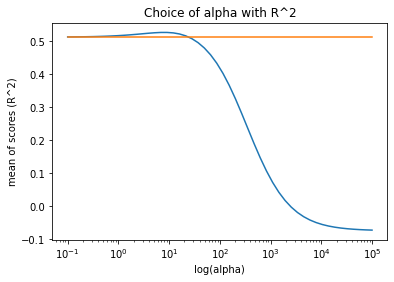

In [10]:
## PLOT R2 ERROR :
ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,CV_ridge.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [R2_lr, R2_lr])
plt.xlabel("log(alpha)")
plt.ylabel("mean of scores (R^2)")
plt.title("Choice of alpha with R^2")
plt.plot()

In the course, the score considered is not the $R^2$ as in the sklearn method, but the Mean Square Error. Let's implement our MSE score in the CV : 

{'alpha': 8.286427728546842}

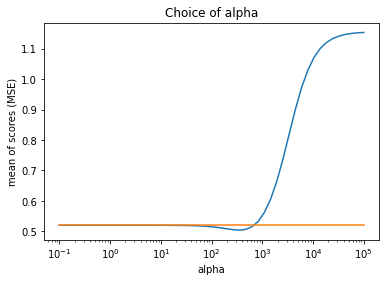

In [11]:
## USE MSE SCORE IN CV : 
param_grid = {"alpha":np.logspace(-5,5,50)}
lm_ridge = linear_model.Ridge()

CV_ridge = model_selection.GridSearchCV(lm_ridge, param_grid = param_grid, 
                                        scoring = 'neg_mean_squared_error', cv = 5)
CV_ridge.fit(X_train_std, y_train)

## CV LINEAR REGRESSION TO COMPARE WITH SAME METHODS :
CV_lr = model_selection.GridSearchCV(linear_model.LinearRegression(), 
                                     param_grid={}, scoring = "neg_mean_squared_error",cv=5)
CV_lr.fit(X_train_std, y_train)
MSE_lr = CV_lr.cv_results_['mean_test_score'].mean()

ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,-CV_ridge.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [-MSE_lr, -MSE_lr])
plt.xlabel("alpha")
plt.ylabel("mean of scores (MSE)")
plt.title("Choice of alpha")
plt.plot()

CV_ridge.best_params_

And let's affine the possible $\alpha$ : 

{'alpha': 7.906043210907698}

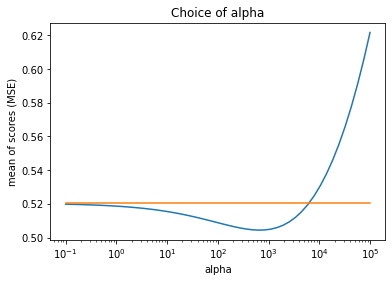

In [12]:
## USE MSE SCORE IN CV : 
param_grid = {"alpha":np.logspace(-1,2,50)}
lm_ridge = linear_model.Ridge()

CV_ridge = model_selection.GridSearchCV(lm_ridge, param_grid = param_grid, 
                                        scoring = 'neg_mean_squared_error', cv = 5)
CV_ridge.fit(X_train_std, y_train)

## CV LINEAR REGRESSION TO COMPARE WITH SAME METHODS :
CV_lr = model_selection.GridSearchCV(linear_model.LinearRegression(), 
                                     param_grid={}, scoring = "neg_mean_squared_error",cv=5)
CV_lr.fit(X_train_std, y_train)
MSE_lr = CV_lr.cv_results_['mean_test_score'].mean()

ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,-CV_ridge.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [-MSE_lr, -MSE_lr])
plt.xlabel("alpha")
plt.ylabel("mean of scores (MSE)")
plt.title("Choice of alpha")
plt.plot()

CV_ridge.best_params_

Now that we have the best parameter set, let's fit the linear ridge regression on the whole X_train set :


In [13]:
## EXTRACT BEST PARAM SET AND FIT ON WHOLE X_train :
kwargs = CV_ridge.best_params_
lm_ridge = linear_model.Ridge(**kwargs)
lm_ridge.fit(X_train, y_train)

y_pred = lm_ridge.predict(X_test_std)

### Regularization path : 
Let's see the evolution of each coefficient while $\alpha$ grows

In [14]:
regulation_paths = []
for alpha in alpha_values:
    lm_ridge = linear_model.Ridge(alpha = alpha)
    lm_ridge.fit(X_train_std,y_train)
    coeffs = lm_ridge.coef_
    regulation_paths.append(coeffs)

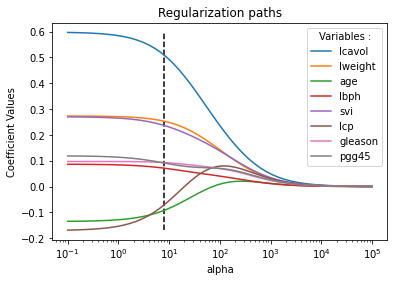

In [15]:
ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values, regulation_paths)
plt.xlabel("alpha")
plt.ylabel("Coefficient Values")
plt.legend(X_train.columns, title = "Variables :")
plt.title("Regularization paths")
## VERTICAL LINE WITH THE BEST ALPHA :
best_alpha = kwargs.values()
ax.vlines(best_alpha, ymin = np.min(regulation_paths), ymax = np.max(regulation_paths), 
          color = "black", linestyle="dashed", label="best_alpha")
plt.legend(X_train.columns, title = "Variables :")
plt.show()

# 3. Lasso Regression : 
Let's copy the Ridge code and modify it : 

{'alpha': 0.07543120063354623}


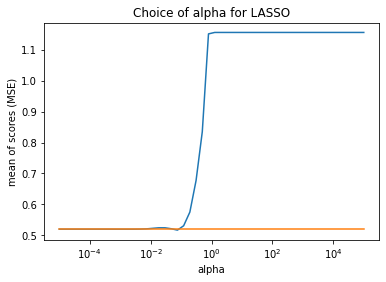

In [16]:
## INIT CV : 
alpha_values = np.logspace(-5, 5, 50)
param_grid = {"alpha": alpha_values}
lm_lasso = linear_model.Lasso()

## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_lasso = model_selection.GridSearchCV(lm_lasso, param_grid = param_grid, 
                                        scoring = 'neg_mean_squared_error', cv = 5)
CV_lasso.fit(X_train_std, y_train)

## CV LINEAR REGRESSION TO COMPARE WITH SAME METHODS :
CV_lr = model_selection.GridSearchCV(linear_model.LinearRegression(), 
                                     param_grid={}, scoring = "neg_mean_squared_error",cv=5)
CV_lr.fit(X_train_std, y_train)
MSE_lr = CV_lr.cv_results_['mean_test_score'].mean()

## PLOT MSE COMPARISON : 
ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,-CV_lasso.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [-MSE_lr, -MSE_lr])
plt.xlabel("alpha")
plt.ylabel("mean of scores (MSE)")
plt.title("Choice of alpha for LASSO")
plt.plot()


kwargs = CV_lasso.best_params_
print(kwargs)

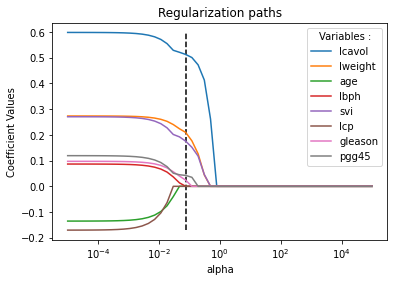

In [17]:
## REGULARIZATION PATH :

regulation_paths = []
for alpha in alpha_values:
    lm_lasso = linear_model.Lasso(alpha = alpha)
    lm_lasso.fit(X_train_std,y_train)
    coeffs = lm_lasso.coef_
    regulation_paths.append(coeffs)
    
## PLOT REG. PÄTHS :
ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values, regulation_paths)
plt.xlabel("alpha")
plt.ylabel("Coefficient Values")
plt.legend(X_train.columns, title = "Variables :")
plt.title("Regularization paths")
## VERTICAL LINE WITH THE BEST ALPHA :
best_alpha = kwargs.values()
ax.vlines(best_alpha, ymin = np.min(regulation_paths), ymax = np.max(regulation_paths), 
          color = "black", linestyle="dashed", label="best_alpha")
plt.legend(X_train.columns, title = "Variables :")
plt.show()

# Conclusion of TP :
## Conclusion 1 : 
There are directly CV implemented for the linear regression :'( Let's see about that on the Lasso for example :

In [22]:
lassoCV = linear_model.LassoCV(alphas = alpha_values, cv = 5)
lassoCV.fit(X_train_std,y_train)
lassoCV.predict(X_test_std)

array([1.96685737, 2.50877292, 1.96509163, 2.20557506, 2.34303814,
       1.88343013, 2.52125214, 2.56066359, 3.51837696, 1.06166177,
       1.00627954, 1.32436218, 2.16121038, 3.65677206, 1.79377574,
       3.47190565, 3.00657742, 3.68624983, 3.37334766, 3.65522562])

Note that it is not possible to detail the MSE as we did with this sklearn method. There are other tools linked, such that "sklearn.linear_model.lasso_path" for example. See also "lars" to go further

# 4 Elastic Net : 
And what about Elastic Net ? It is quite the same ! 
Caution : only the alpha is set, and it is possible ton control beta with the "ratio" parameter.

In [25]:
elasticnet_CV = linear_model.ElasticNetCV(cv = 5)
elasticnet_CV.fit(X_train_std,y_train)
elasticnet_CV.predict(X_test_std)

array([1.96326545, 2.517157  , 1.9320099 , 2.18322653, 2.35870375,
       1.88102706, 2.51910553, 2.57958989, 3.5290913 , 1.07097575,
       0.98692071, 1.31862759, 2.15549314, 3.68577169, 1.77173252,
       3.46930879, 3.09571723, 3.67737933, 3.35952776, 3.64931384])

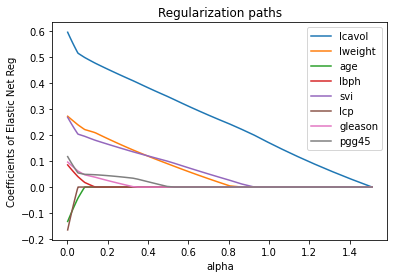

In [54]:
## REG PATHS :
enet_alphas, enet_paths, enet_dual_gap = linear_model.enet_path(X_train_std, y_train)

plt.figure(1)
plt.plot(enet_alphas,enet_paths.T)
plt.title("Regularization paths")
plt.xlabel("alpha")
plt.ylabel("Coefficients of Elastic Net Reg")
plt.legend(X_train.columns)
plt.show()

# Brouillon pour le test : 

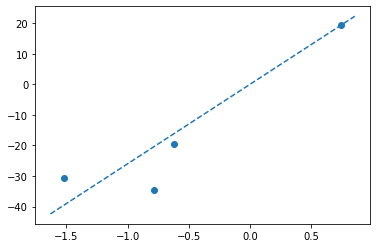

In [66]:
X = np.array([-0.78768,-1.51760513, 0.74416271,-0.62288928 ]).T
y = np.array([-34.59703199,-30.79543532,19.31018182,-19.44809959]).T
plt.scatter(X,y)
def abline(intercept, slope):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

abline(0,26)
